In [36]:
import hopsworks
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import os
import joblib

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
titanic_passengers_fg = fs.get_feature_group(name="titanic_passengers",version=1)
titanic_tickets_fg = fs.get_feature_group(name="titanic_tickets",version=1)
titanic_survived_fg = fs.get_feature_group(name="titanic_survived",version=1)

In [24]:
query = titanic_passengers_fg.select_except(["name"]).join(
    titanic_tickets_fg.select_all()).join(titanic_survived_fg.select_all())

2022-12-15 13:18:34,907 INFO: USE `dowlingj_featurestore`
2022-12-15 13:18:35,340 INFO: SELECT `fg2`.`passenger_id` `passenger_id`, `fg2`.`sex` `sex`, `fg2`.`age` `age`, `fg2`.`age_child` `age_child`, `fg2`.`age_teen` `age_teen`, `fg2`.`age_young_adult` `age_young_adult`, `fg2`.`age_middle_aged` `age_middle_aged`, `fg2`.`age_pensioner` `age_pensioner`, `fg0`.`fare` `fare`, `fg0`.`embarked` `embarked`, `fg1`.`survived` `survived`
FROM `dowlingj_featurestore`.`titanic_passengers_1` `fg2`
INNER JOIN `dowlingj_featurestore`.`titanic_tickets_1` `fg0` ON `fg2`.`passenger_id` = `fg0`.`passenger_id`
INNER JOIN `dowlingj_featurestore`.`titanic_survived_1` `fg1` ON `fg2`.`passenger_id` = `fg1`.`passenger_id`


,passenger_id,sex,age,age_child,age_teen,age_young_adult,age_middle_aged,age_pensioner,fare,embarked,survived
0,866,0,42.0,0,0,0,1,0,13.0000,0,1
1,159,1,28.0,0,0,1,0,0,8.6625,0,0
2,109,1,38.0,0,0,1,0,0,7.8958,0,0
3,659,1,23.0,0,0,1,0,0,13.0000,0,0
4,99,0,34.0,0,0,1,0,0,23.0000,0,1
5,131,1,33.0,0,0,1,0,0,7.8958,1,0
6,140,1,24.0,0,0,1,0,0,79.2000,1,0
7,35,1,28.0,0,0,1,0,0,82.1708,1,0
8,569,1,28.0,0,0,1,0,0,7.2292,1,0
9,708,1,42.0,0,0,0,1,0,26.2875,0,1


In [25]:
try:
    fv = fs.get_feature_view(name="titanic", version=1)
except:
    fv = fs.create_feature_view(name="titanic", 
                                version=1, 
                                query=query, 
                                labels=["survived"])

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fv/titanic/version/1


In [26]:
X_train, X_test, y_train, y_test = fv.train_test_split(test_size=0.2)
X_train

2022-12-15 13:19:08,592 INFO: USE `dowlingj_featurestore`
2022-12-15 13:19:09,069 INFO: SELECT `fg2`.`passenger_id` `passenger_id`, `fg2`.`sex` `sex`, `fg2`.`age` `age`, `fg2`.`age_child` `age_child`, `fg2`.`age_teen` `age_teen`, `fg2`.`age_young_adult` `age_young_adult`, `fg2`.`age_middle_aged` `age_middle_aged`, `fg2`.`age_pensioner` `age_pensioner`, `fg0`.`fare` `fare`, `fg0`.`embarked` `embarked`, `fg1`.`survived` `survived`
FROM `dowlingj_featurestore`.`titanic_passengers_1` `fg2`
INNER JOIN `dowlingj_featurestore`.`titanic_tickets_1` `fg0` ON `fg2`.`passenger_id` = `fg0`.`passenger_id`
INNER JOIN `dowlingj_featurestore`.`titanic_survived_1` `fg1` ON `fg2`.`passenger_id` = `fg1`.`passenger_id`


,passenger_id,sex,age,age_child,age_teen,age_young_adult,age_middle_aged,age_pensioner,fare,embarked
0,866,0,42.0,0,0,0,1,0,13.0000,0
1,159,1,28.0,0,0,1,0,0,8.6625,0
2,109,1,38.0,0,0,1,0,0,7.8958,0
3,659,1,23.0,0,0,1,0,0,13.0000,0
5,131,1,33.0,0,0,1,0,0,7.8958,1
...,...,...,...,...,...,...,...,...,...,...
886,52,1,21.0,0,0,1,0,0,7.8000,0
887,748,0,30.0,0,0,1,0,0,13.0000,0
888,347,0,40.0,0,0,1,0,0,13.0000,0
889,527,0,50.0,0,0,0,1,0,10.5000,0


In [27]:
y_train

,survived
0,1
1,0
2,0
3,0
5,0
...,...
886,0
887,1
888,1
889,1


In [28]:
# Train our model with the Scikit-learn binary classifier algorithm using our features (X_train) and labels (y_train)
model = GradientBoostingClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train.values.ravel())

GradientBoostingClassifier(n_estimators=1000, random_state=42)

In [29]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)
results

array([[88, 27],
       [19, 45]])

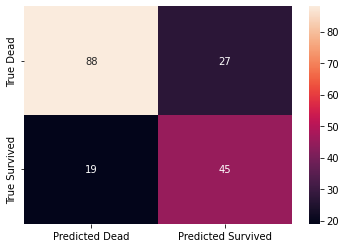

In [30]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Dead', 'True Survived'], 
                                ['Predicted Dead', 'Predicted Survived'])

cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()
fig.show()

In [37]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'titanic_model' directory will be saved to the model registry. Create the dir, first.
model_dir="titanic_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/titanic_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    


# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
titanic_model = mr.python.create_model(
    name="titanic_modal", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="titanic Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
titanic_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/398/models/titanic_modal/1


Model(name: 'titanic_modal', version: 1)